<a href="https://colab.research.google.com/github/untold02/XAI/blob/main/Copy_of_LIME_for_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Generating Posthoc Explanation using LIME**

**Main Agenda:**

1.   Black box models and Post-hoc Explanation Techniques
2.   LIME (Theory)
3.   Implementation of LIME
4.   Explanation Results





#1. **BLACK BOX**

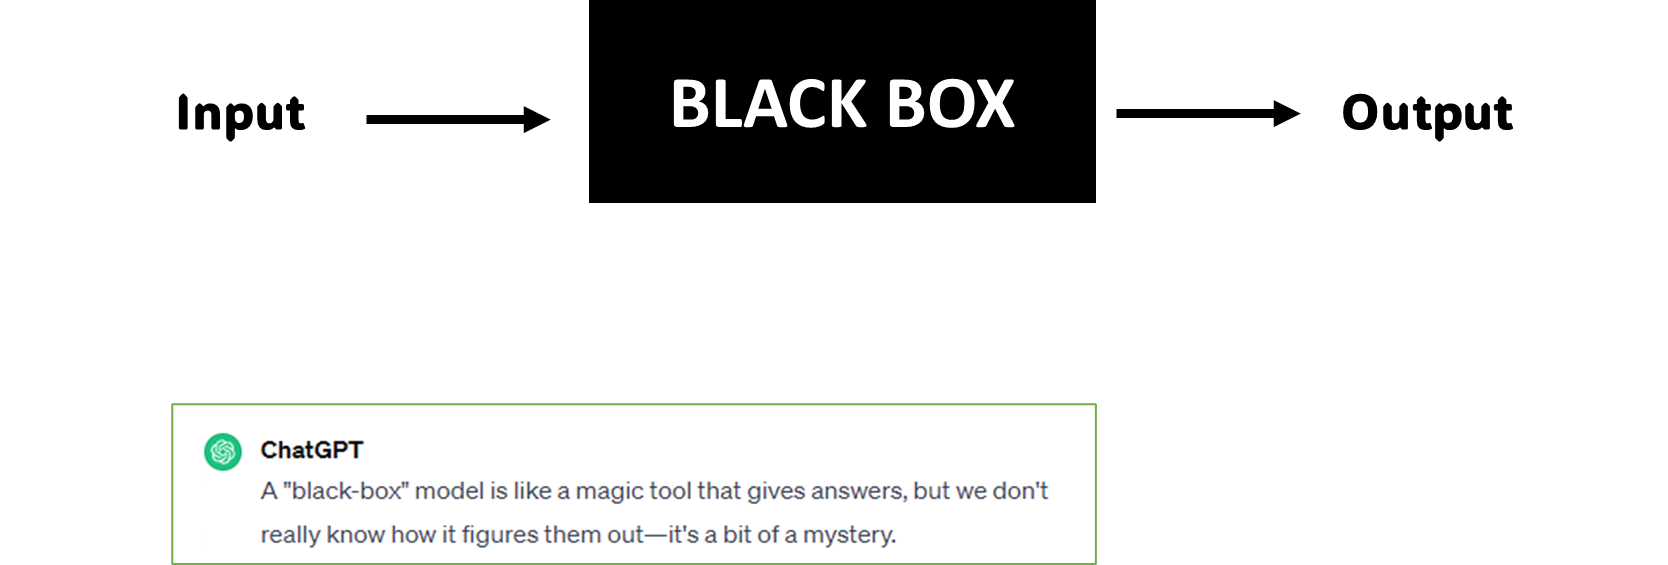

# **Some Posthoc Explanation Techniques :**

<ol>
<li>LIME
<li> SHAP
<li> Anchors

#2. **LIME (Local Interpretable Model-Agnostic Explanations)** *from ["Why Should I Trust You?": Explaining the Predictions of Any Classifier"](https://arxiv.org/abs/1602.04938)*

**<li>LIME** helps us to understand the predictions of complex machine learning models, even when they act like "black-boxes".

<li> It works by creating simplified, understandable models (surrogate model) for small local parts of the data.

**<li>LIME** perturbs or changes the input data and observes how the model's prediction changes, allowing us to interpret and trust the model's decisions in specific instances.





**HOW LIME WORKS**
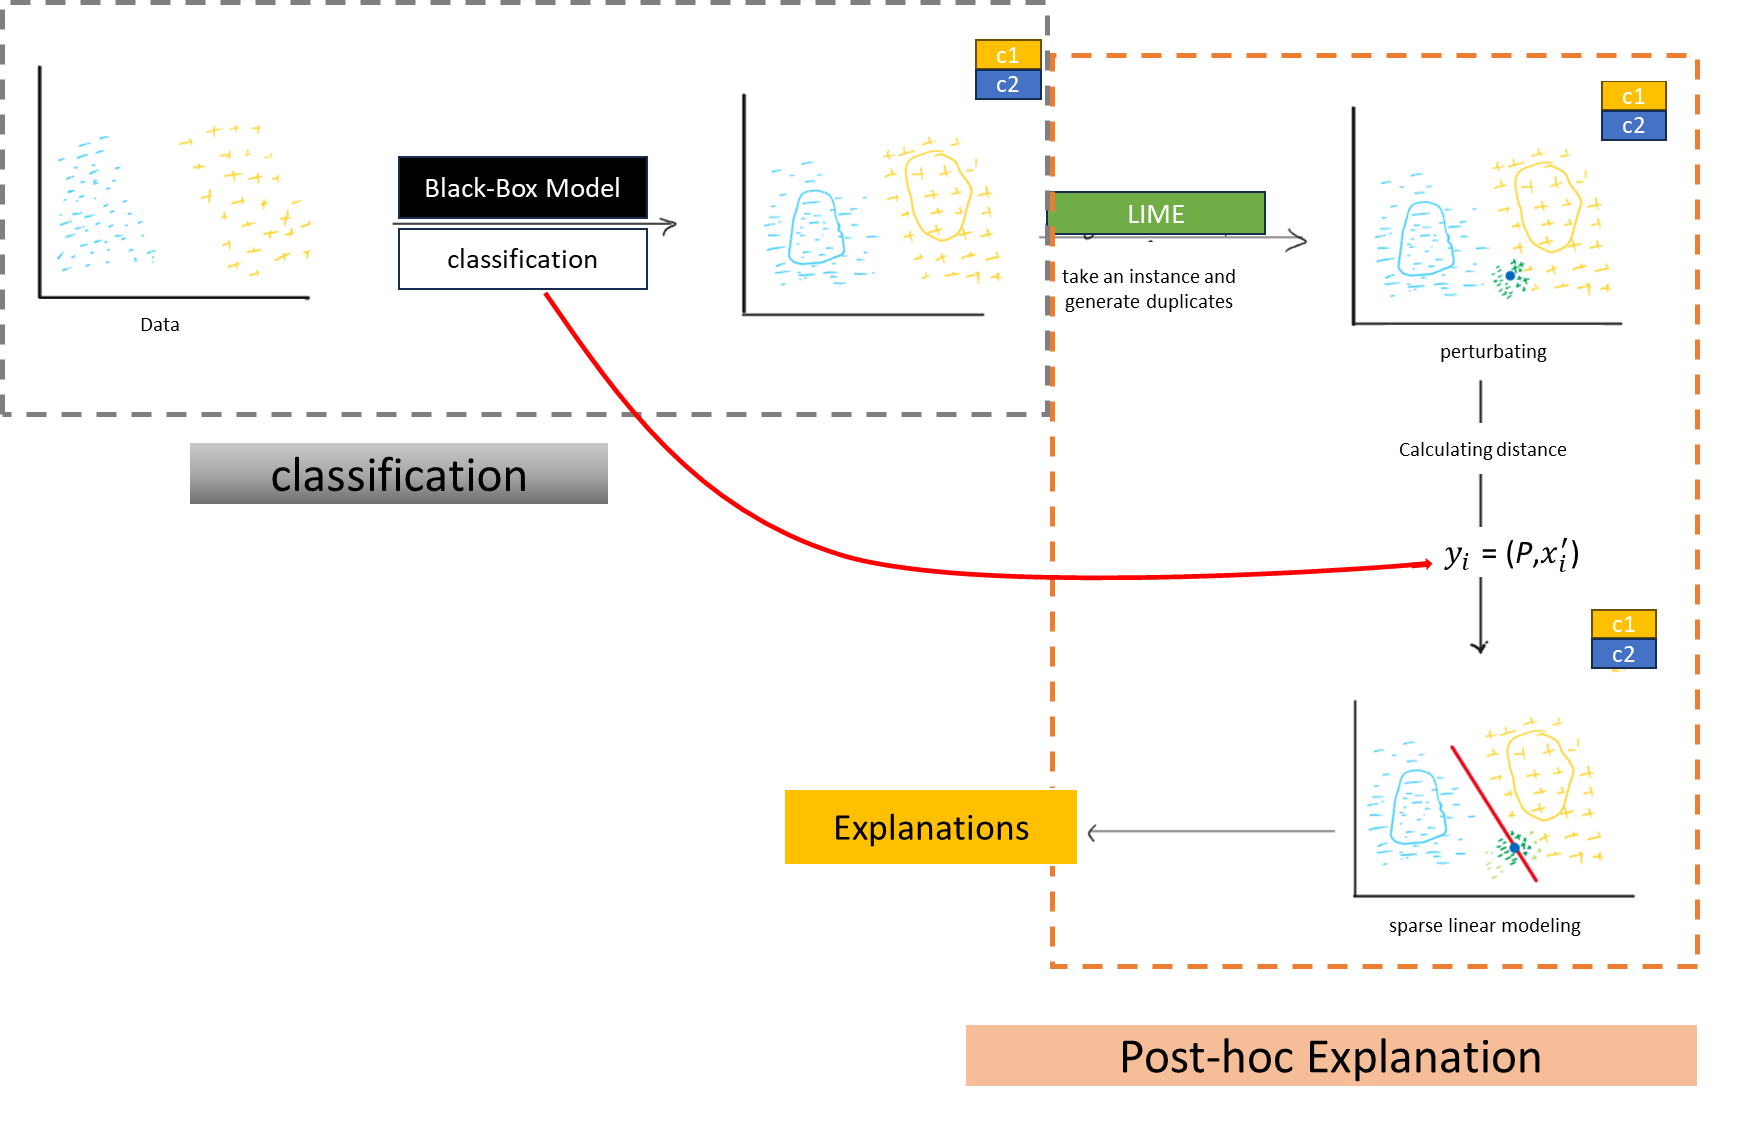

<ol>
<li> Permute data
<li> Calculate distance between permutations and original observations
<li> Make predictions on new data using complex model.
<li> Pick up 'm' features best describing the black-box model outcomes from the premuted data.
<li> Fit a simple model to the permuted data with 'm' features and similarity scores as weights.
<li> Feature weights from the simple model make explanations for the complex models local behavior.

# 3.**LIME for Image (Implementation)**

"lime_image"

(https://github.com/marcotcr/lime)

---

1. *'lime_image'* module provides an explainer that can generate an explanation for images.
Here, we are using the 'digits' dataset to explain how to generate an explanation using this module.

2. The 'digit' dataset is available from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). It has 8×8 sized images for 0-9 handwritten digits.

 ** Load the dataset and train a black-box model**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier #our black-box model
from sklearn.datasets import load_digits  #our dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
#loading dataset
data = load_digits()

for line in data.DESCR.split('\n')[5:20]:
  print(line)

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.



In [ ]:
X,y = data.data, data.target
print("data size: ", X.shape,y.shape)

#split the dataset
X_train, X_test, y_train, y_test=train_test_split(X,y, train_size=0.80, test_size=0.2)
print(f"train sizes: {X_train.shape}, {y_train.shape}\n",f"test sizes:{X_test.shape}, {y_test.shape}")

#we are using a gradient boosting classifier (black-box)
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test,y_test)

test_prediction = model.predict(X_test)
mse = mean_squared_error(y_test, test_prediction)

print("Train Accuracy: %.2f"%train_accuracy)
print("Test Accuracy: %.2f"%test_accuracy)
print(f"Mean Squared Error: {mse:.2f}")

data size:  (1797, 64) (1797,)
train sizes: (1437, 64), (1437,)
 test sizes:(360, 64), (360,)
Train Accuracy: 1.00
Test Accuracy: 0.97
Mean Squared Error: 0.21


**Explaining Individual Prediction using "LimeImageExplainer"**

The ***LimeImageExplainer*** explains images by highlighting which parts of the image have contributed to the prediction of a particular class.

Some important parameters of ***LimeImageExplainer***:

<ol>
<li> feature_selection :

 This parameter decides how LIME selects the most important features(parts of the image) when explaining predictions (made by a BB model).

**Options:**
<ul>
<li>
forward_selection: Select features in a forward (gradual) manner.
</li>
<li>
lasso_path: Use LASSO(L1 regularization) to select features.
</li>
<li>
auto : Automatically choose a suitable method
</li>
<li>
none: Do not perform feature selection
</li>
</ul>
</li>

<li> random_state :

 This parameter helps ensure reproducibility of results. It accepts integer or np.RandomState object specifying random state. Setting a random state means that if we run the explanation process again, we will get the same results.
 </li>


 **Why These Parameters Matter:**
<ul><li>Choosing the right feature_selection method affects how LIME identifies the important parts of the image.<li>
Setting random_state ensures that the random processes involved in LIME (like sampling) produce consistent results when you run the explanation multiple times.
</ul>
</ol>

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=24ebe4a45cb100e2b963ec78952effe585e2193bb9e251d61ad018f406d7ee71
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


labels:  0
[array([9.99968561e-01, 5.09388556e-07, 1.07871203e-06, 1.71314456e-06,
       8.51657730e-07, 1.90647299e-06, 3.35572506e-07, 3.16018627e-07,
       1.08672439e-05, 1.38610538e-05])]


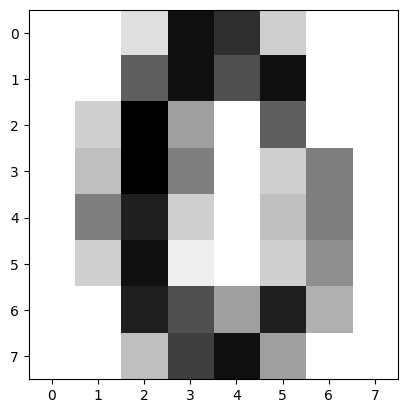

In [ ]:
from skimage.color import gray2rgb, rgb2gray
import numpy as np
import matplotlib.pyplot as plt

def prediction_function(images):
  total_probabilities = []
  for image in images:
    #convert image to grayscale (if not already)
    gray_image = rgb2gray(image) if len(image.shape)==3 else image

    #prediction made by a BB model
    predictions = model.predict_proba(gray_image.reshape(1,-1))[0]
    predictions_label = np.argmax(predictions)
    print(f"labels: ", predictions_label)
    #append
    total_probabilities.append(predictions)

  return total_probabilities

print(prediction_function([X_test[1].reshape(8,8)]))
plt.imshow(X_test[1].reshape(8,8), cmap=plt.cm.gray_r, interpolation="nearest")



In [ ]:
import random
import matplotlib.pyplot as plt

index = random.randint(1,len(X_test))

print(f"Prediction : {model.predict(X_test[index].reshape(1,-1))[0]}")
print(f"Actual : {y_test[index]}")

Prediction : 0
Actual : 0


In [ ]:
sample = X_test[index].reshape(8,8)
sample.shape

(8, 8)

In [ ]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    X_test[index].reshape(8,8),
    classifier_fn=prediction_function,
    top_labels=3,
    num_samples=150 #no of perturbed images
    )
explanation_image, explanation_mask = explanation.get_image_and_mask(
    y_test[index],
    positive_only=True,
    num_features=64,
    hide_rest=True
    )

Text(0.5, 1.0, 'Explanation')

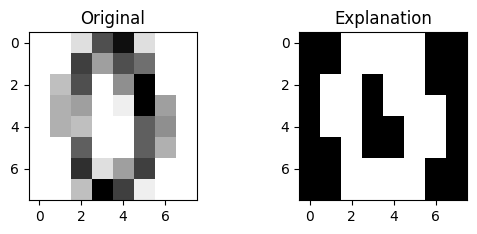

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
plt.imshow(X_test[index].reshape(8,8),cmap=plt.cm.gray_r, interpolation="nearest")
plt.title("Original")

plt.subplot(2,2,2)
plt.imshow(mark_boundaries(explanation_image, explanation_mask))
plt.title("Explanation")

# 4.**Analyzing Explanation Results**

   **Explanations for correctly predicted instances**
   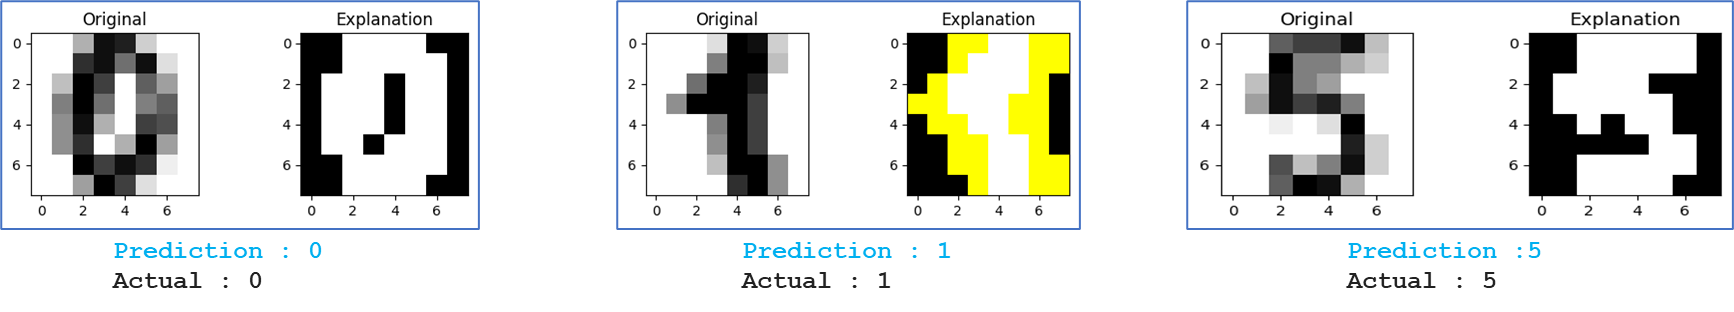

**Locally Faithful**
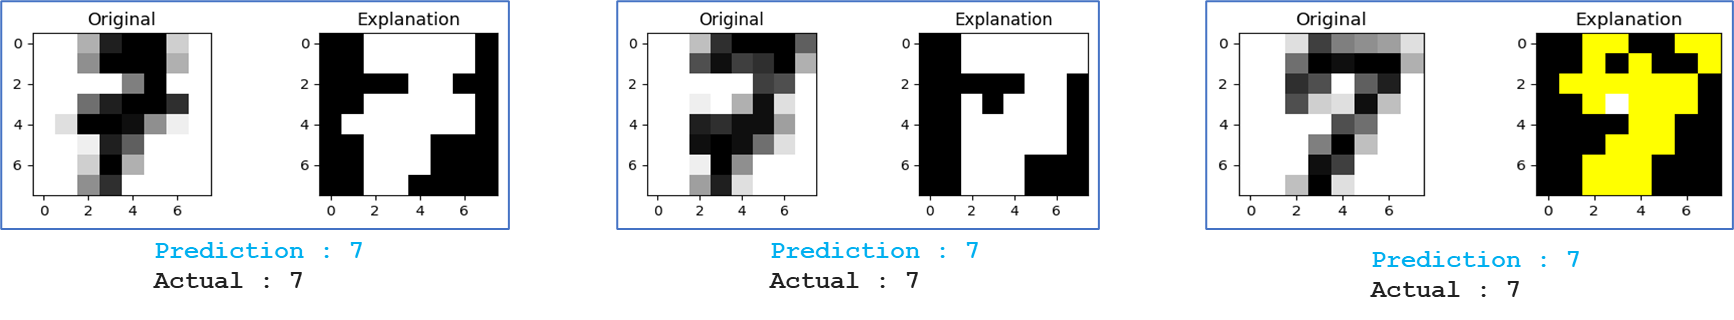

**Explanations for Wrong Predictions**

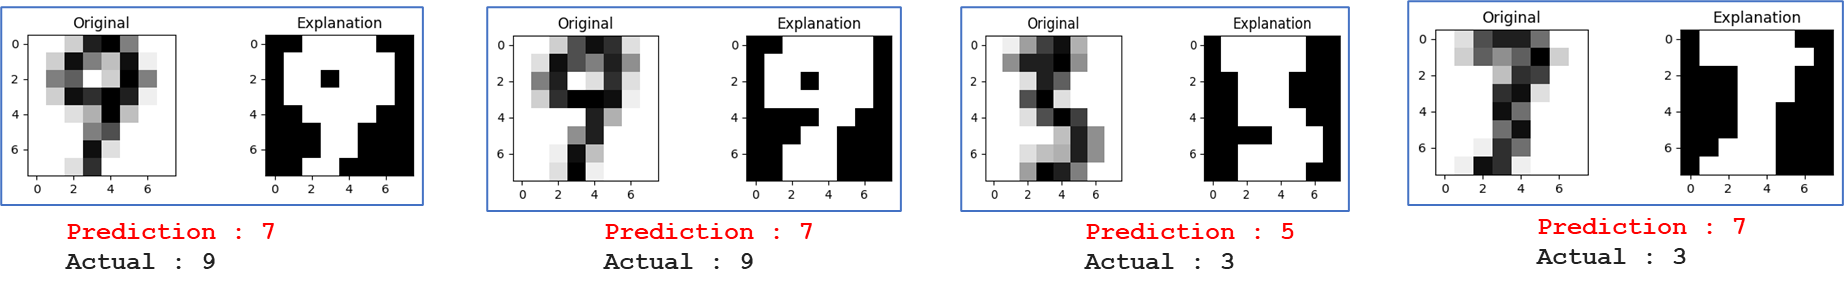

In [ ]:
def select_instance(class_to_explain):
    #select 10 instances from test set belong to the same class
    no_instances_to_explain = 10
    indices = np.where(y_test==class_to_explain)[0]#use [0] to get 1D array

    #select 10 instances from the specified class
    select_indices = np.random.choice(indices, no_instances_to_explain)
    instance_list = [X_test[idx] for idx in select_indices]
    return instance_list

In [ ]:
instance_list_class1 = select_instance(1)
instance_list_class2 = select_instance(2)

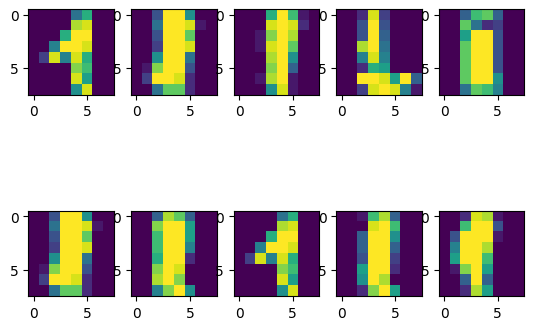

In [ ]:
plt.figure()
for index, image in enumerate(instance_list_class1):
    plt.subplot(2,5,index+1)
    plt.imshow(image.reshape(8,8))
plt.show()

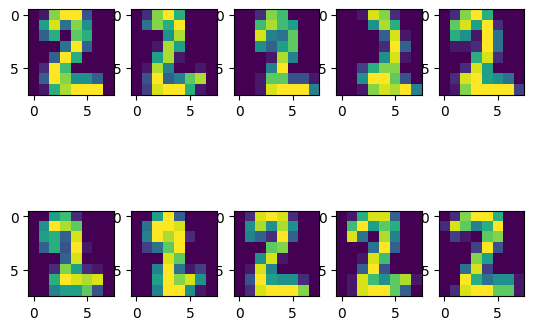

In [ ]:
plt.figure()
for index, image in enumerate(instance_list_class2):
    plt.subplot(2,5,index+1)
    plt.imshow(image.reshape(8,8))
plt.show()

In [ ]:
import time
def explanation_list(instance_list):
    explanation_list = []
    for index, image in enumerate(instance_list):
        print("Iteration :", index+1)
        image = image.reshape(8, 8)
        # Get the explanation for the sample image
        explanation_cnn = explainer.explain_instance(image,
                                            prediction_function,
                                            top_labels=5, hide_color=0,
                                            num_samples=150)

        temp_cnn, mask_cnn = explanation_cnn.get_image_and_mask(explanation_cnn.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

        explanation_list.append(temp_cnn)

        #plot the explanations
        plt.subplot(2,5,index+1)
        plt.imshow(mark_boundaries(temp_cnn , mask_cnn))

    return explanation_list


In [ ]:
plt.figure()
start = time.time()
explanation_list_for_cluster_c1 = explanation_list(instance_list_class1)
end = time.time()
print(f"Time taken : {end-start:.2f}sec")
plt.show()

In [ ]:
plt.figure()
start = time.time()
explanation_list_for_cluster_c2 = explanation_list(instance_list_class2)
end = time.time()
print(f"Time taken : {end-start:.2f}sec")
plt.show()

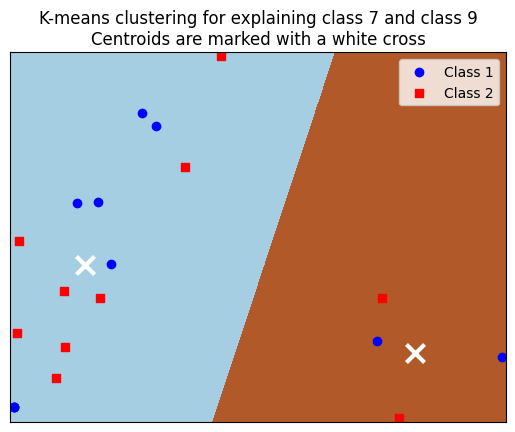

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming explanation_list_for_cluster_c1 and explanation_list_for_cluster_c2 are defined

# Function to compute PCA for each explanation
def compute_pca_for_explanations(explanation_list):
    pca = PCA(n_components=2)
    reduced_features =  np.array([explanation.flatten() for explanation in explanation_list])
    reduced_features = pca.fit_transform(reduced_features)

    return reduced_features.squeeze()

# Compute PCA for class 1 explanations
reduced_features_c1 = compute_pca_for_explanations(explanation_list_for_cluster_c1)

# Compute PCA for class 2 explanations
reduced_features_c2 = compute_pca_for_explanations(explanation_list_for_cluster_c2)

# Concatenate two explanations
explanations_concatenate = np.concatenate((reduced_features_c1, reduced_features_c2), axis=0)

# Apply K-Means clustering
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(explanations_concatenate)

# Step size of the mesh
h = 0.02
x_min, x_max = explanations_concatenate[:, 0].min() - 1, explanations_concatenate[:, 0].max() + 1
y_min, y_max = explanations_concatenate[:, 1].min() - 1, explanations_concatenate[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the last trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

# Plot points for class 1 with marker 'o'
plt.scatter(
    reduced_features_c1[:, 0],
    reduced_features_c1[:, 1],
    c='b', marker='o', label='Class 1'
)

# Plot points for class 2 with marker 's'
plt.scatter(
    reduced_features_c2[:, 0],
    reduced_features_c2[:, 1],
    c='r', marker='s', label='Class 2'
)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10
)

plt.title(
    "K-means clustering for explaining class 7 and class 9\n"
    "Centroids are marked with a white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.legend()
plt.show()


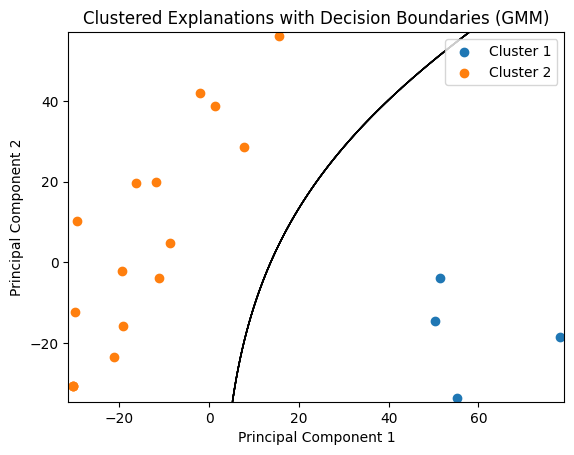

In [ ]:
from sklearn.mixture import GaussianMixture


# Apply Gaussian Mixture Model clustering
num_clusters = 2
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
cluster_labels = gmm.fit_predict(explanations_concatenate)

# Visualize the clustered explanations and decision boundaries
for cluster_id in range(num_clusters):
    cluster_points = explanations_concatenate[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id + 1}')

# Plot decision boundaries
h = .02  # Step size in the mesh
x_min, x_max = explanations_concatenate[:, 0].min() - 1, explanations_concatenate[:, 0].max() + 1
y_min, y_max = explanations_concatenate[:, 1].min() - 1, explanations_concatenate[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', linewidths=1)

plt.title('Clustered Explanations with Decision Boundaries (GMM)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [ ]:
explanation_list_for_cluster_c1 = np.array(explanation_list_for_cluster_c1)
type(explanation_list_for_cluster_c1)

numpy.ndarray

In [ ]:
explanation_list_for_cluster_c1.shape

(10, 8, 8, 3)

In [ ]:
explanation_list_for_cluster_c2 = np.array(explanation_list_for_cluster_c2)

In [ ]:
# Convert lists to NumPy arrays and flatten them to 2D arrays
explanation_list_for_cluster_c1 = np.vstack([explanation.flatten() for explanation in explanation_list_for_cluster_c1])
explanation_list_for_cluster_c2 = np.vstack([explanation.flatten() for explanation in explanation_list_for_cluster_c2])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#compute cosine similarity
cosine_similarities = cosine_similarity(explanation_list_for_cluster_c1,explanation_list_for_cluster_c2)

#print the similarity matrix
print("Cosine Similarity Matrix: ",cosine_similarities)

Cosine Similarity Matrix:  [[0.60812432 0.64454912 0.67870888 0.55847128 0.60049133 0.72386663
  0.86166759 0.5936329  0.65286819 0.57717251]
 [0.75134839 0.76893687 0.73220373 0.5865156  0.57376404 0.75297144
  0.79352185 0.7517967  0.70660505 0.63100771]
 [0.71756652 0.79006656 0.7286548  0.63040781 0.59818162 0.80724858
  0.7470709  0.7073324  0.7389387  0.66290509]
 [0.81618836 0.78976716 0.76700227 0.67693062 0.63114726 0.75773429
  0.77827873 0.79175669 0.79508273 0.75560955]
 [0.78087258 0.79704574 0.73798771 0.6022049  0.59020667 0.77586818
  0.79991065 0.78298443 0.74249454 0.67787856]
 [0.71756652 0.79006656 0.7286548  0.63040781 0.59818162 0.80724858
  0.7470709  0.7073324  0.7389387  0.66290509]
 [0.65921197 0.61263576 0.80991506 0.69687269 0.46741494 0.75936262
  0.73949819 0.60935065 0.68991414 0.61826854]
 [0.80060174 0.76796923 0.75898396 0.63953597 0.62001597 0.75617901
  0.77543176 0.76972003 0.77036387 0.72284437]
 [0.71756652 0.79006656 0.7286548  0.63040781 0.59818

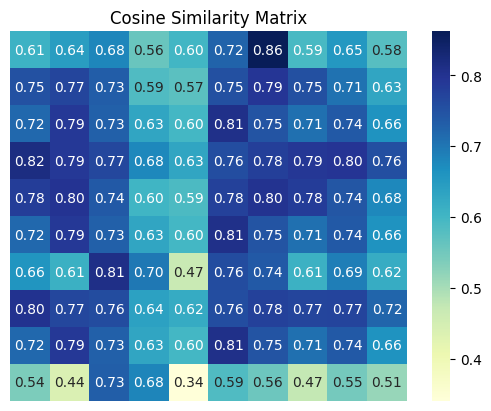

In [ ]:
import seaborn as sns
# Visualize the cosine similarity matrix as a heatmap
sns.heatmap(cosine_similarities, cmap="YlGnBu", annot=True, fmt=".2f", xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Matrix")
plt.show()

In [ ]:
# Set a cosine similarity threshold to identify common arrays
cosine_similarity_threshold = 0.95

# Find indices of common arrays
common_array_indices = np.argwhere(cosine_similarities >= cosine_similarity_threshold)

# Extract common arrays
common_arrays_c1 = explanation_list_for_cluster_c1[common_array_indices[:, 0]]
common_arrays_c2 = explanation_list_for_cluster_c2[common_array_indices[:, 1]]

# Print the number of common arrays found
print(f"Number of common arrays: {len(common_arrays_c2)}")

Number of common arrays: 0
